## Student: Megi Dervishi

# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [91]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import min_span_tree
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
from skimage.transform import resize_local_mean
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy as sp
import networkx as nx

### Better Plotting

In [2]:
# modified functions from utils.py to implement the passing of axis as a parameter

def plot_clusters(X, Y, axis, fignum='data', show=False):
    K = Y.max() + 1
    axis.set_title(f"{fignum}")
    for k in range(K):
        axis.plot(X[Y == k, 0], X[Y == k, 1], 'o')

def plot_graph_matrix(X, Y, W, axis, fignum='graph matrix'):
    plot_edges_and_points(X,Y,W, axis[0])
    axis[1].imshow(W, extent=[0, 1, 0, 1])


def plot_edges_and_points(X, Y, W, axis, title=''):
    colors=['go-', 'ro-', 'co-', 'ko-', 'yo-', 'mo-']
    n=len(X)
    G=nx.from_numpy_matrix(W)
    nx.draw_networkx_edges(G, X, ax=axis)
    for i in range(n):
        axis.plot(X[i, 0], X[i, 1], colors[int(Y[i])])
    axis.set_title(title)


def plot_clustering_result(X, Y, W, spectral_labels, kmeans_labels,  axis, normalized_switch=0):
    plot_edges_and_points(X, Y, W, axis[0], 'ground truth')
    if normalized_switch:
        plot_edges_and_points(X, spectral_labels, W, axis[1], 'unnormalized laplacian')
    else:
        plot_edges_and_points(X, spectral_labels, W, axis[1], 'spectral clustering')
    if normalized_switch:
        plot_edges_and_points(X, kmeans_labels, W, axis[2], 'normalized laplacian')
    else:
        plot_edges_and_points(X, kmeans_labels, W, axis[2], 'k-means')

def plot_the_bend(X, Y, W, spectral_labels, eigenvalues_sorted, axis):
    plot_edges_and_points(X, Y, W, axis[0], 'ground truth')
    plot_edges_and_points(X, spectral_labels, W, axis[1], 'spectral clustering')
    axis[2].plot(np.arange(0, len(eigenvalues_sorted), 1), eigenvalues_sorted, 'v:')


## Generating the data

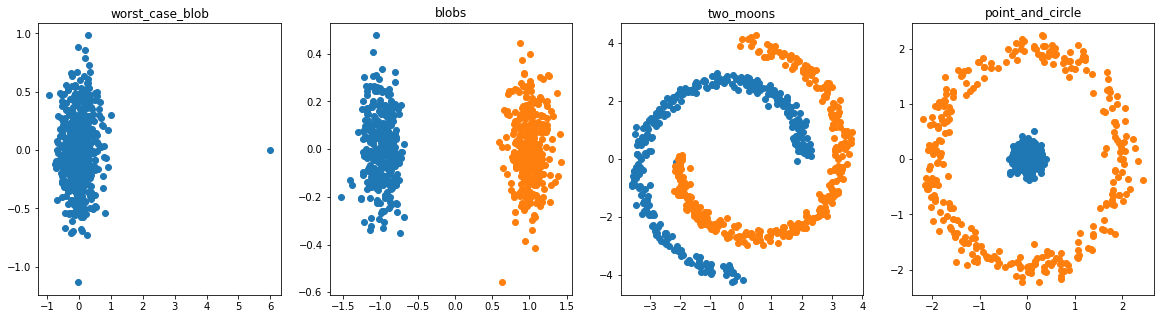

In [3]:
#Example
# show different clustering for different types of data
name = ["worst_case_blob", "blobs", "two_moons", "point_and_circle"]
data = []
fig, ax = plt.subplots(1,4, figsize=(20,5))
for i,fn in enumerate([worst_case_blob, blobs, two_moons, point_and_circle]):  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    data.append((X,Y))
    plot_clusters(X,Y, ax[i], fignum=name[i])


# You can check the documentation of each function to see the optional parameters, e.g.:
# worst_case_blob?

## Building similarity graph

In [4]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = np.exp(-(skm.pairwise.euclidean_distances(X,X)**2)/ (2*var))

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        #np.fill_diagonal(similarities, 0)
        W = similarities*(similarities >= eps)
        
    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        np.fill_diagonal(similarities, 0) #remove self-similarity
        a = np.sort(similarities, axis=1) #sort by ascending order 
        W = similarities*(similarities >= a[:,-k]) #take the topk (descending order)
        W = (W + W.T)/2 #make graph symmetric/undirected 

    return W


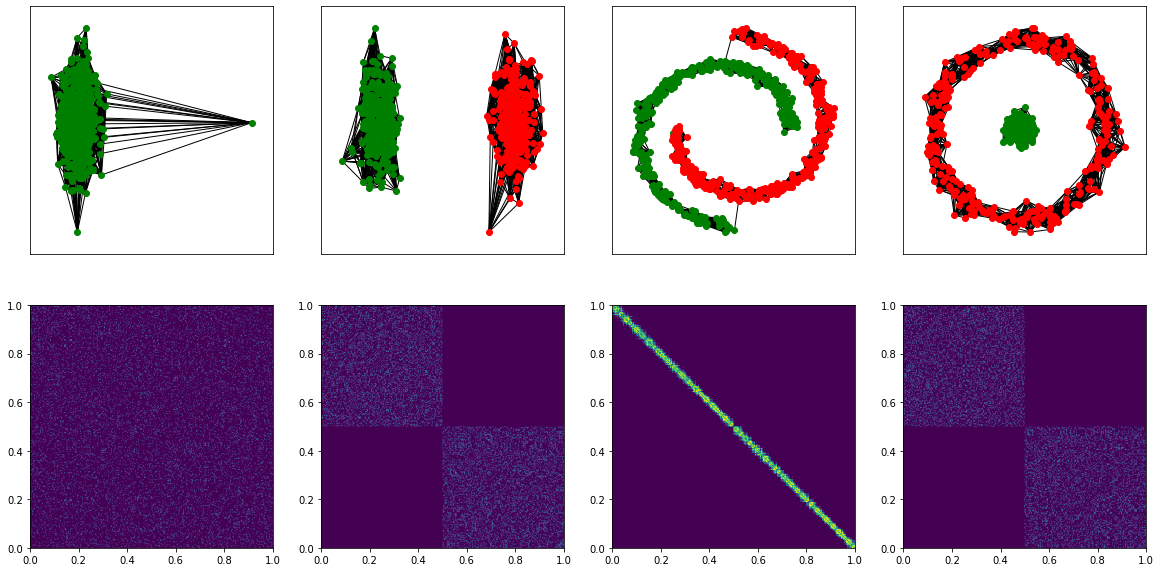

In [5]:
# Example
# show the visualization of W for different types of data
Ws = []
ks = [20,20,16,20]
fig, ax = plt.subplots(2,4, figsize=(20,10))
for i,(X,Y) in enumerate(data):
    W = build_similarity_graph(X, k=ks[i])
    #W[0, 599] = 1    # add two placeholder edges to reproduce example picture
    #W[10, 500] = 1   # 
    Ws.append(W)
    plot_graph_matrix(X, Y, W, ax[:,i])  # shows the graph and the visualization of W
plt.show()

## Computing the Laplacian

In [6]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L = np.zeros(W.shape)
    D = np.diag(W @ np.ones(W.shape[0]))
    n = W.shape[0]
    
    # for example (unnormalized): L = D - W
    if laplacian_normalization == "unn": L = D - W
    elif laplacian_normalization == "sym": # L = I - D^-1/2 W D^-1/2
        Dinv = np.sqrt(np.linalg.inv(D))
        L = np.eye(n) - Dinv@ W @ Dinv
    elif laplacian_normalization == "rw": # L = I - D^-1 W
        L = np.eye(n) - np.linalg.inv(D) @ W
    else: 
        raise(TypeError("Unknown laplacian normalization"))
    
    return L

## Clustering

In [7]:
# useful for Question 1.2 

def how_to_choose_epsilon(X,Y, axis=None, var=1.0):
    """
    Consider the distance matrix with entries dist(x_i, x_j) (the euclidean distance between x_i and x_j)
    representing a fully connected graph.
    One way to choose the parameter epsilon to build a graph is to choose the maximum value of dist(x_i, x_j) where
    (i,j) is an edge that is present in the minimal spanning tree of the fully connected graph. Then, the threshold
    epsilon can be chosen as exp(-dist(x_i, x_j)**2.0/(2*sigma^2)).

    Parameters
    ----------
    :param X: (n x m) matrix of m-dimensional samples
    :param Y: (n, ) vector with cluster assignments
    :param var:  the sigma value for the exponential function, already squared
    :return eps: the max epsilon chosen for the graph to stay connected
    :return W: the ajacency matrix for epsilon graph

     use the distance function and the min_span_tree function to build the minimal spanning tree min_tree                   
     - var: the exponential_euclidean's sigma2 parameter          
     - dists: (n x n) matrix with euclidean distance between all possible couples of points                   
     - min_tree: (n x n) indicator matrix for the edges in the minimal spanning tree                           
    """
    # dists[i, j] = euclidean distance between x_i and x_j
    dists = skm.pairwise.euclidean_distances(X,X)
    min_tree = min_span_tree(dists)

    """
    set threshold epsilon to the max weight in min_tree 
    """
    distance_threshold = np.max(dists[min_tree])
    eps = np.exp(-distance_threshold**2.0/(2*var))
    """
    use the build_similarity_graph function to build the graph W  
     W: (n x n) dimensional matrix representing                    
        the adjacency matrix of the graph
       use plot_graph_matrix to plot the graph                    
    """
    W = build_similarity_graph(X, var=var, eps=eps, k=0)
    if axis is not None: plot_graph_matrix(X, Y, W, axis) #chose to plot or not
    return eps, W

In [8]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    
    E, U = sp.linalg.eig(L) #eigenval, eigenvec
    E, U = E.real, U.real
    valsort = np.argsort(E)
    E, U = E[valsort], U[:,valsort]
    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    # Question 2.3 strategy implementation when num_classes = None
    if not num_classes:
        #choose the first 15 eigenvalues for easier computations
        #hence we assume that there won't be 15 well-separated clusters or more
        #of course the following method can be easily generalised to more clusters.
        E_15 = E[:15]
        heuristic_fn = np.diff(E_15)/np.arange(1,15)**2
        num_classes = np.argmax(heuristic_fn) +1 #choose among the first big peaks
        
    # Question 2.1 strategy implementation when chosen_eig_indices = None
    if not chosen_eig_indices:
        chosen_eig_indices = list(range(1, num_classes))
        
    #print(f"Chosen eig indices: {chosen_eig_indices}")
    kmean = KMeans(n_clusters=num_classes)
    Y = kmean.fit_predict(U[:,chosen_eig_indices])
    return Y, num_classes

Calculating..
Plotting..


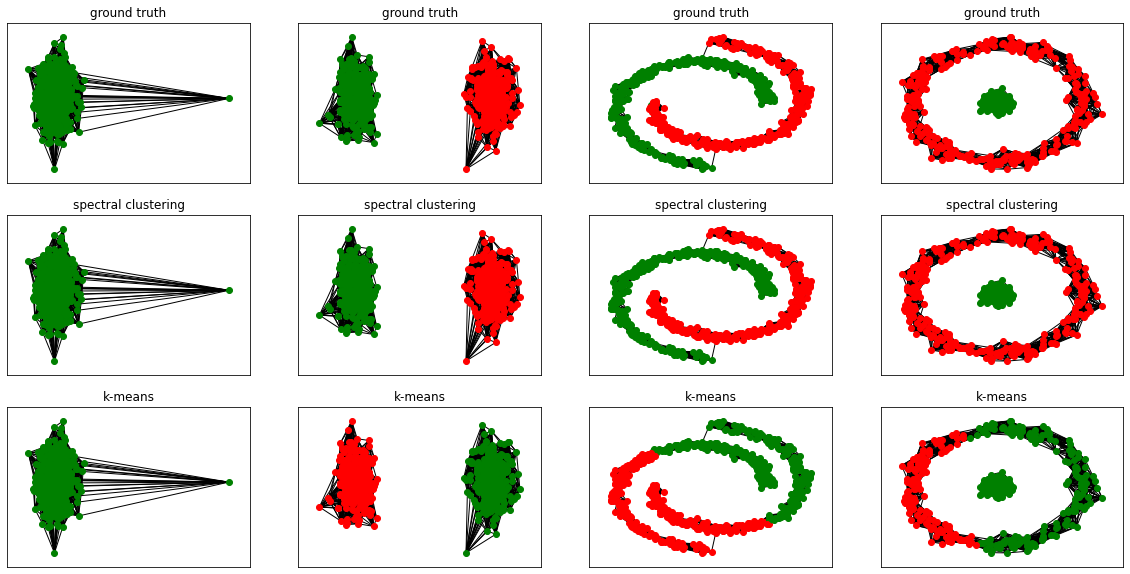

In [9]:
# Example
fig, ax = plt.subplots(3,4, figsize=(20,10))
num_classes = [1, 2, 2, 2] # values chosen as a result of question 2.3
eig = [[0],[0,1],[1,2],[0,1]] #values chosen as a result of question 2.1/2.2
print("Calculating..")
for i,(X,Y) in enumerate(data):
    L = build_laplacian(Ws[i])
    Y_rec, num_class = spectral_clustering(L, chosen_eig_indices=eig[i], num_classes=num_classes[i])
    # Plot results, comparing to KMeans
    plot_clustering_result(X, Y, Ws[i], Y_rec, KMeans(num_class).fit_predict(X), ax[:,i])
print("Plotting..")
plt.show()

## Parameter sensitivity 

In [35]:
def parameter_sensitivity(axis, parameter_type = 'eps', parameter_candidate = np.linspace(0.1, 1, 10)):
    """
    :param parameter_type: The parameter to study sensitivity on either 'k' or 'eps'.
    :param parameter_candidate: The possible values of parameter_type

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = None

    """
    Choose candidate parameters
    """
    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec, _ = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    axis.plot(parameter_candidate, parameter_performance)
    axis.set_title(f'parameter sensitivity ({parameter_type})')
    

In [113]:
#parameter_sensitivity()
#parameter_sensitivity('k', np.arange(1, 100))

## Image segmentation

In [53]:
def image_segmentation(axis, show_orig = False, input_img='four_elements.bmp', k = 0, eps = 0, var = 1, laplacian_normalization='unn',chosen_eig_indices=None, num_classes = 2, large = False):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    :param k: Value of k for building the graph (k = 0 -> eps)
    :param eps: Value of eps to build the graph if k = 0. If eps is None eps is chosen automatically from the minimum spanning tree.
    :param var: Variance in the gaussian similarity
    :param laplacian_normalization: Normalization chosen for the laplacian, either 'unn', 'sym', 'rw'.
    :param chosen_eig_indices: The choice of eigen indices, if None selected automatically.
    :param num_classes: Number of classes to which we need to cluster.
    :param large: Boolean saying whether we have to downsample the image.
    """
    filename = os.path.join('data', input_img)
    X = io.imread(filename)
    
    # Question 3.2-3.3 - Dealing with a large image
    if large: 
        w, h, c = X.shape #put to rgb
        if c == 4:
            X = X[:, :, :-1]
            c = 3
        X_orig = X.copy()
        X = resize_local_mean(X, [50, 50, c]) #resize
        
    
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    
    if not eps: #if eps = None then choose an epsilon
        eps = how_to_choose_epsilon(Xr,None)[0]
    W = build_similarity_graph(Xr, var=var, k=k, eps = eps)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec, num_classes = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    Y_rec = Y_rec.reshape(im_side, im_side)
    if large: #before plot resize to original shape
        X = X_orig
        Y_rec = resize_local_mean(Y_rec, [w, h])
        
    if show_orig:
        axis[0].set_title(f"Original image")
        axis[0].imshow(X)
        axis[1].set_title(f"Clustering for {num_classes} classes.")
        axis[1].imshow(Y_rec)
    else:
        axis[0].set_title(f"Clustering for {num_classes} classes.")
        axis[0].imshow(Y_rec)
    

In [15]:
#image_segmentation(num_classes = 4)

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

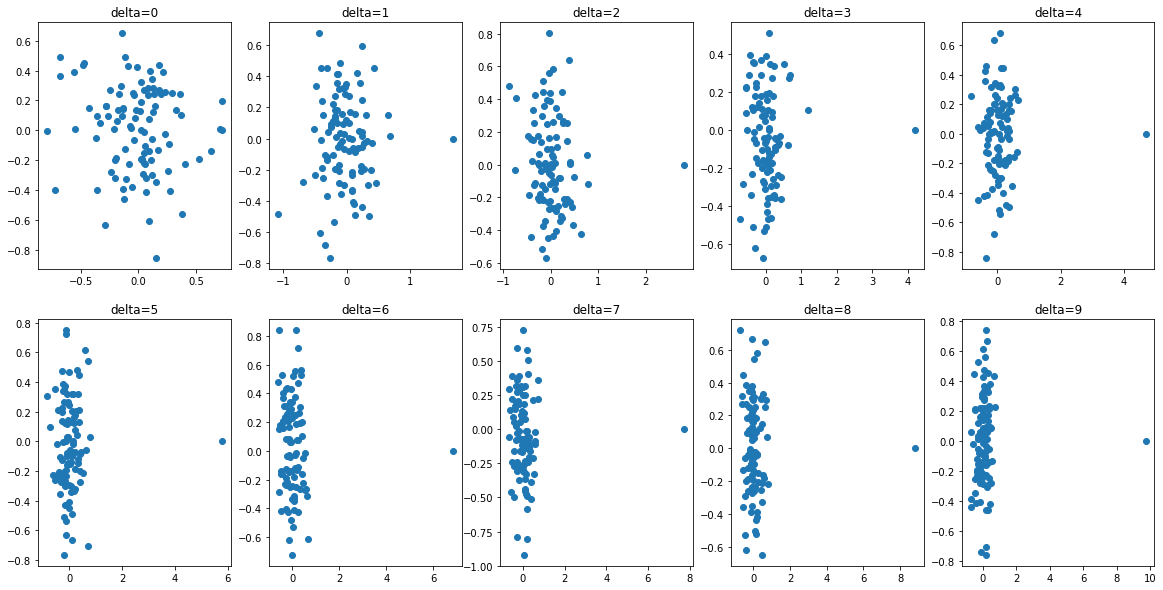

In [16]:
#?worst_case_blob
data_worst = []
fig, ax = plt.subplots(2,5, figsize=(20,10))
for d in range(10):
    X, Y = worst_case_blob(num_samples=100, delta=d)
    data_worst.append((X,Y))
    plot_clusters(X,Y, ax[d//5, d%5], fignum=f"delta={d}")
plt.show()

The parameter `delta` controls the separation of an outlier point from the blob of data. When `delta = 0` the outlier is not serparated from the blob, however as delta increases the separation is `delta`-away. 

Formally the coordinates of the outlier point are:

\begin{align} 
    x\text{-coordinate } &= \max_{(x,y)\in \text{blob}} x + \text{delta}\\
    y\text{-coordinate} &= 0
\end{align}
where $(x,y)$ are points in the blob.

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

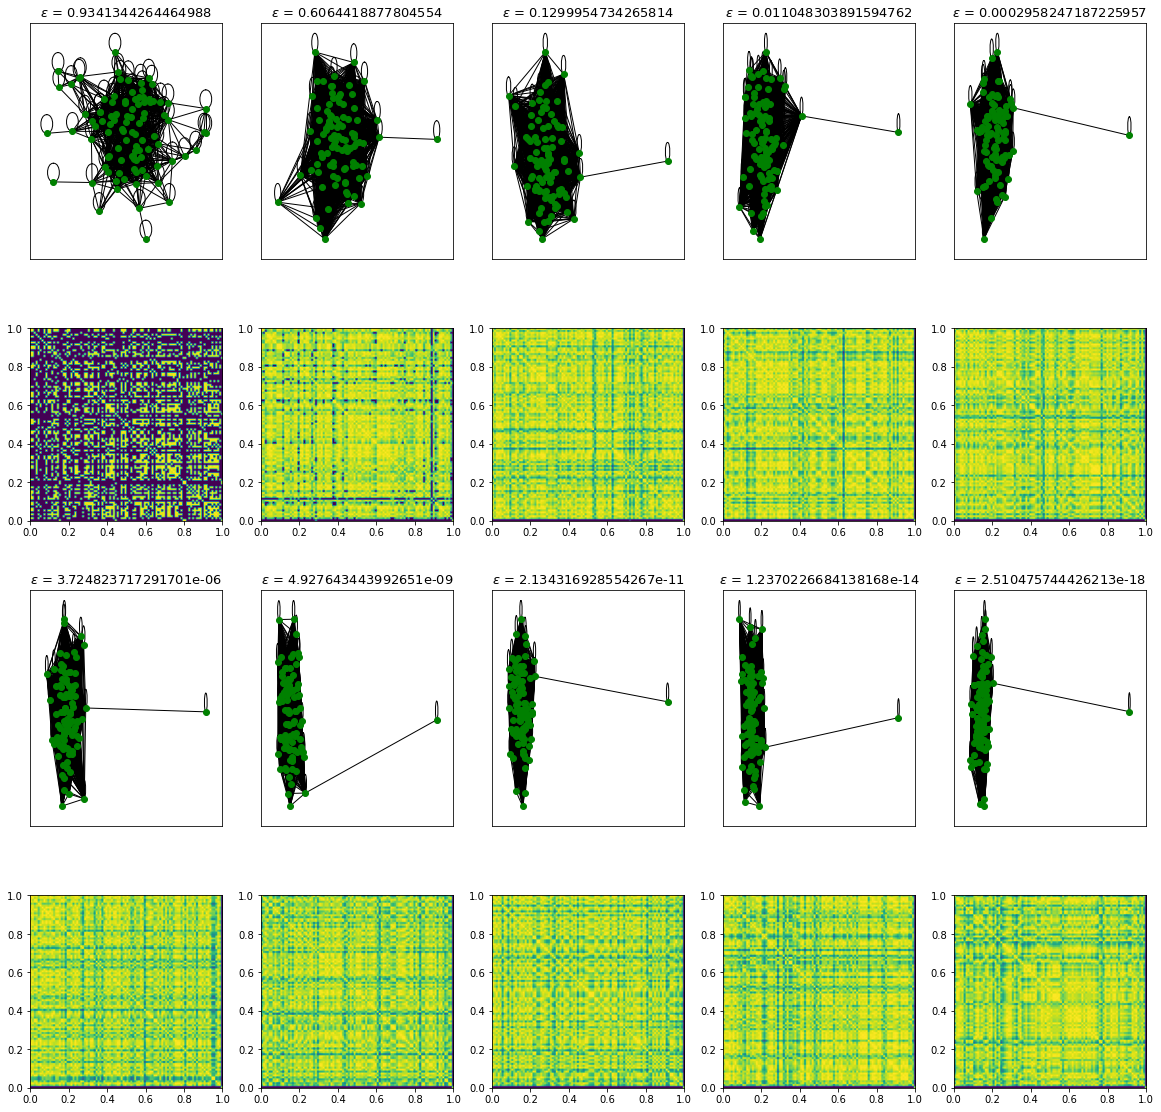

In [17]:
fig, ax = plt.subplots(4,5, figsize=(20,20))
for i,(X,Y) in enumerate(data_worst):
    if i<5: 
        eps,_ = how_to_choose_epsilon(X,Y,ax[:2,i])
        ax[0,i].set_title(f"$\epsilon$ = {eps} ", size=13)
    else: 
        eps,_ = how_to_choose_epsilon(X,Y,ax[2:,i-5])
        ax[2,i-5].set_title(f"$\epsilon$ = {eps}", size=13)
plt.show()

First of all we would like to answer the question: given a certain graph what is the maximum $\epsilon$ that ensures the graph stays connected. One way to compute that, is by finding the maximal edge in the minimum spanning tree and using it as a threshold. The function that does this is `how_to_choose_epsilon` shown above.

We observe that as `delta` increases (the outilier goes further away) then we are forced to choose a very low $\epsilon$ in order to keep the graph connected. By choosing a lower $\epsilon$, fewer edges are being eliminated and the adjacency matrix becomes more dense. As a result we lose a lot of local information which would have been more useful in clustering and the matrix graph becomes more noisy.

As a result $\epsilon$-similarity may not be the best choice if outliers are present in the data. 

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

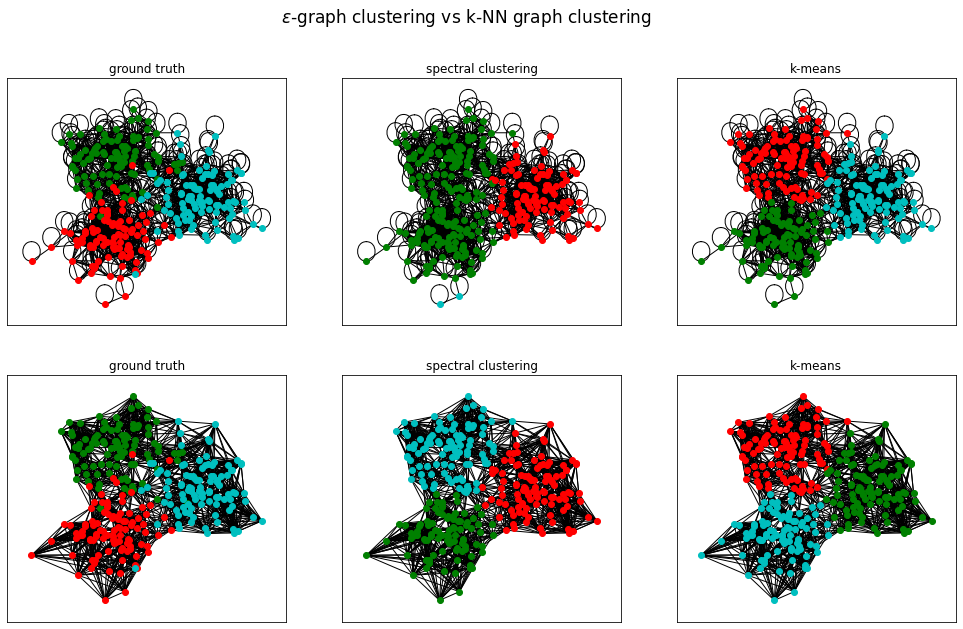

In [18]:
X, Y = blobs(num_samples=300, n_blobs=3, blob_var=0.5) 

fig, ax = plt.subplots(2,3, figsize=(17,10))
fig.suptitle("$\epsilon$-graph clustering vs k-NN graph clustering", size=17, y=0.98)
#W for epsilon graph, W for knn graph
Ws = [how_to_choose_epsilon(X,Y)[1], build_similarity_graph(X, k=20)]
for i in range(2):
    L = build_laplacian(Ws[i])
    Y_rec, num_class = spectral_clustering(L, chosen_eig_indices=[0,1,2], num_classes=3)
    # Plot results, comparing to KMeans
    plot_clustering_result(X, Y, Ws[i], Y_rec, KMeans(3).fit_predict(X), ax[i,:])

For the spectral algorithm to work we need two conditions
 - Nodes that are within the same component (cluster) need to be (strongly) connected
 - Nodes between two different components (clusters) can be disconnected or weakly connected
The reason for such conditions is as follows. 

If we build a graph where nodes of a component are not (strongly) connected then the clustering algorithm will not be able to realize that these nodes are part of the same cluster. However we don't want to create to many 'strong' connections between separate clusters as this will confuse the algorithm. As seen in Question 1.2 $\epsilon$-graphs are very sensitive to outliers and hence if there is an outlier (as shown above) we are forced to create strong connections between separate clusters which breaks our clustering algorithm.  In contrast, kNN-graphs are more robust to outliers. 

To support such claims, the above images show spectral clustering performed on an $\epsilon$ graph and on a kNN graph. We can see that the spectral clustering for the $\epsilon$-graph simply assigns all the nodes to the same cluster appart from the outliers, on the other hand we see that the spectral clustering for the kNN graph is able to succesfully separate the clusters in 3 distinct ones.


### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

In [19]:
#useful function to answer Q2.1 and Q2.2
def plot_different_eigen(X,Y, eig, num_classes, graph='fully', show=False): #eig is a list of eigenvector indices e.g. [0]
    fig, ax = plt.subplots(1,3, figsize=(10,3))
    if graph=='fully':
        if show: fig.suptitle(f"Clustering for fully-connected graph using eigenvalues {eig}", size=13, y=1.05)
        W = build_similarity_graph(X, var=1, eps=0, k=0)
    else:
        if show: fig.suptitle(f"Clustering for disconnected graph using eigenvalues {eig}", size=13, y=1.05)
        eps = how_to_choose_epsilon(X,Y)[0]
        W = build_similarity_graph(X, var=1, eps=eps+0.01, k=0)
    L = build_laplacian(W)
    Y_rec, num_class = spectral_clustering(L, chosen_eig_indices=eig, num_classes=num_classes)
    plot_clustering_result(X, Y, W, Y_rec, KMeans(num_class).fit_predict(X), ax)
    plt.show()

-------2 blobs -------


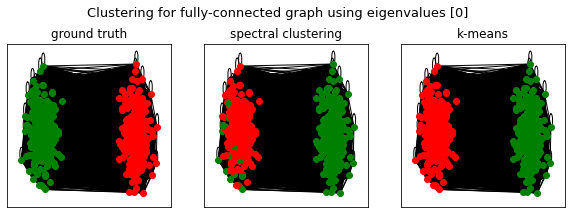

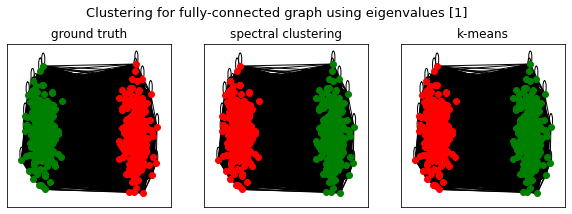

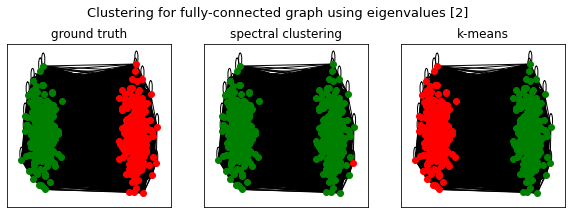

-------3 blobs -------


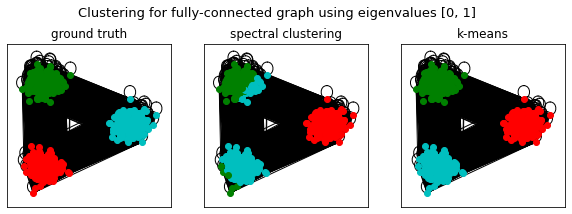

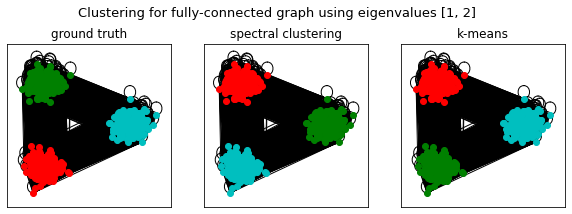

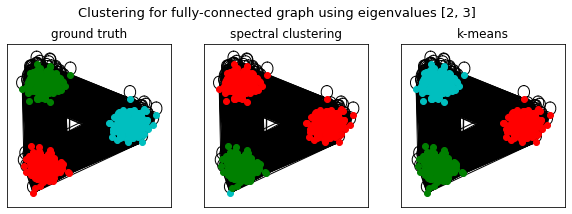

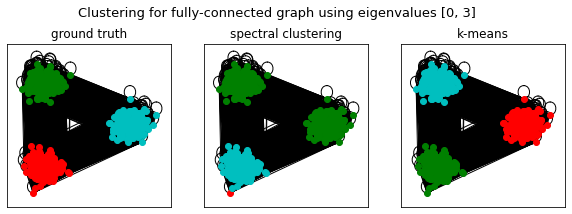

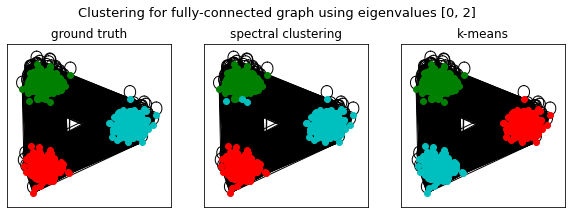

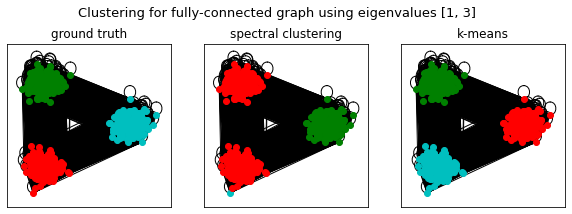

In [20]:
print("-------2 blobs -------")
X, Y = blobs(num_samples=600)
for lambd in [[0],[1],[2]]:
    plot_different_eigen(X,Y, lambd, 2, show=True)
print("-------3 blobs -------")
X, Y = blobs(num_samples=600, n_blobs=3)
for lambd in [[0,1],[1,2],[2,3],[0,3],[0,2],[1,3]]:
    plot_different_eigen(X,Y, lambd, 3, show=True)

We ensure the graph is connected by always using the fully connected graph (`eps=0, k=0`). We perform clustering on 2 blobs and 3 blobs data using different eigenvalues/eigenvector indices. 
Eigenvectors encode useful information about the graph. In particular eigenvectors with smaller eigenvalues (i.e. small eigen indices) encode more coarse-grained information of the graph, while higher eigenvectors encode finer details. 
When performing clustering of data one does not need the finer details but the general structure. Hence we have to use the first-few eigenvectors. 

In fact if we have $n$ distinct-well-separated clusters, the first $n$ eigenvalues, eigenvectors will be linear combinations of the indicator functions of the clusters. Hence using these eigenvectors to perform kMeans will yield a good clustering of our data. 
However we have to be careful that in the connected graph a trivial solution exists. Hence the 0th eigenvector will contain no information. 

Experimentally, we test different combinations of eigenvectors and as expected, the best eigenvector combination to cluster $n$-blobs is $[1, \cdots, n-1]$ eigenvectors.

Therefore in the function of `spectral clustering` when the parameter `chosen-eig-indices = None` one uses the above formula to select the eigenvectors.

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

-------2 blobs -------


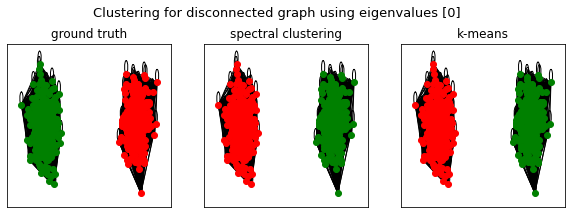

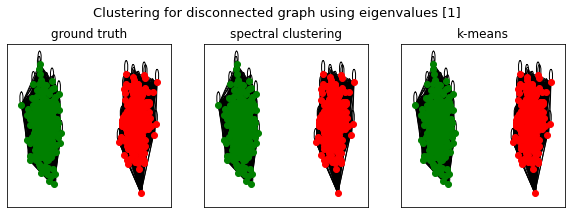

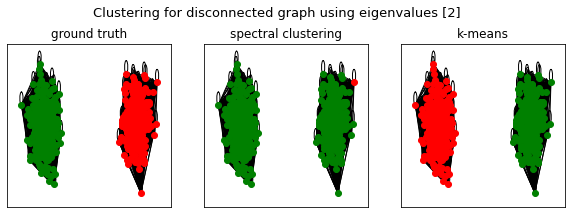

-------3 blobs -------


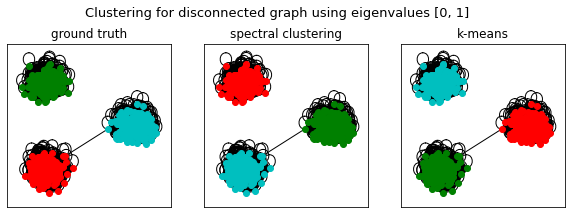

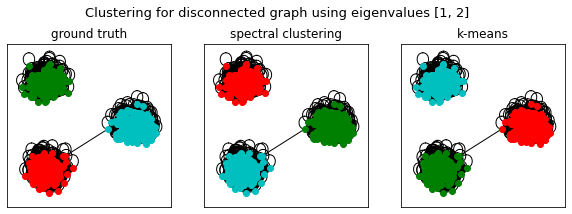

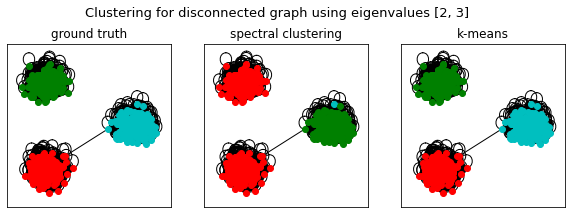

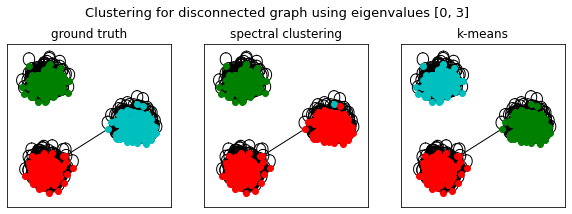

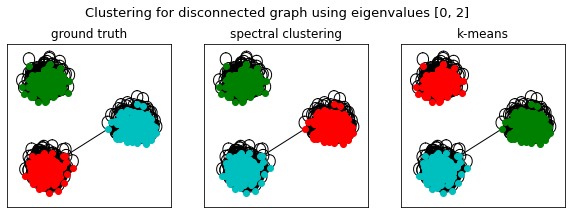

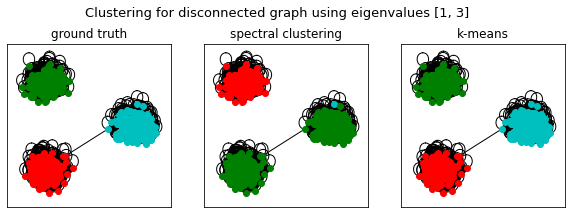

In [18]:
print("-------2 blobs -------")
X, Y = blobs(num_samples=600)
for lambd in [[0],[1],[2]]:
    plot_different_eigen(X,Y, lambd, 2, "disconnected", show=True)
print("-------3 blobs -------")
X, Y = blobs(num_samples=600, n_blobs=3)
for lambd in [[0,1],[1,2],[2,3],[0,3],[0,2],[1,3]]:
    plot_different_eigen(X,Y, lambd, 3, "disconnected", show=True)

The same reasoning as the previous question applies, however we now do not have a trivial solution since the graph is disconnected. In other words the 0th eigenvector does contain useful information. Hence all eigenvectors in between 0 and $n-1$ will contain useful information; call the list of such eigenvectors $U$. Therefore any subset of $U$ of cardinality $n-1$ will give good results. 

Experimentally we indeed see that both $[0,1], [1,2], [0,2]$ give good results for the 3-blob data and $[0], [1]$ give good results for the 2-blob data.

In the function `spectral clustering` one does not need to make a different case from the previous question as the choice $[1, \cdots n-1]$ is still valid.


### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

Calculating..
Plotting..


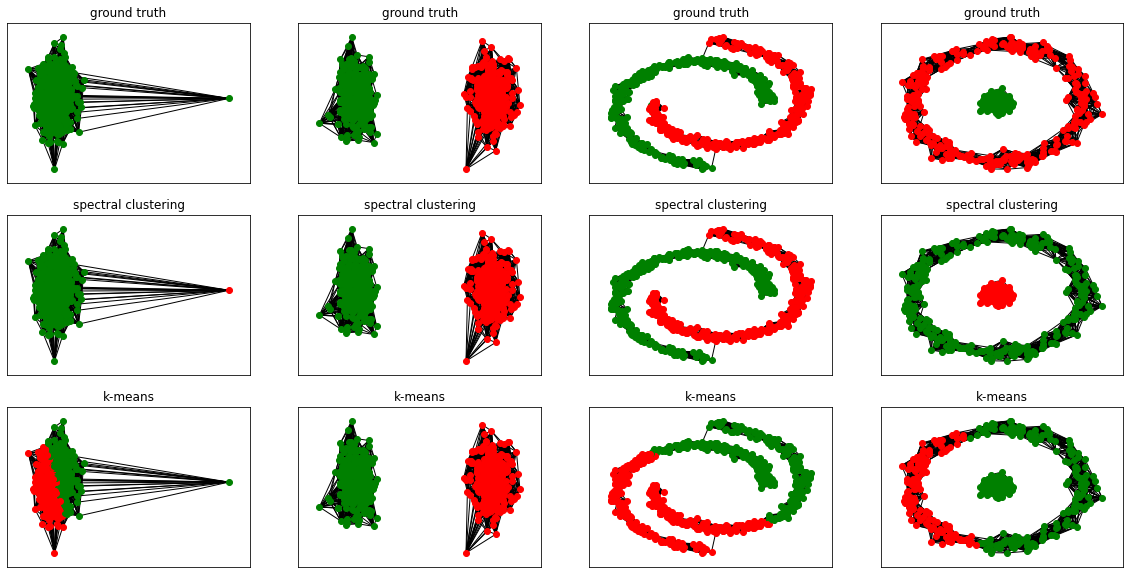

In [22]:
# Spectral clustering without knowing eigen-indices or num_clusters for different data

fig, ax = plt.subplots(3,4, figsize=(20,10))
print("Calculating..")
ks = [20,20,16,20]
for i,(X,Y) in enumerate(data):
    W = build_similarity_graph(X, k=ks[i])
    L = build_laplacian(W)
    Y_rec, num_class = spectral_clustering(L, chosen_eig_indices=None, num_classes=None)
    # Plot results, comparing to KMeans
    plot_clustering_result(X, Y, W, Y_rec, KMeans(num_class).fit_predict(X), ax[:,i])
print("Plotting..")
plt.show()

# Remark: sometimes the two-moons randomly raise a ValueError due to sklearn issues. 
# If that happens re-run the notebook.

𝜎^2 = 0.05


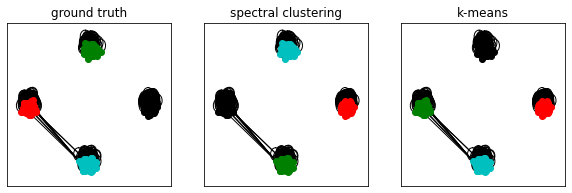

𝜎^2 = 0.15


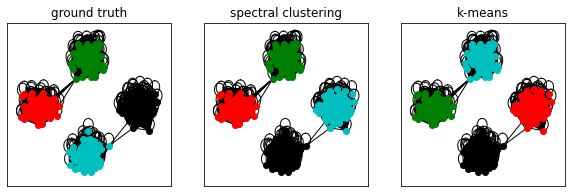

𝜎^2 = 0.2


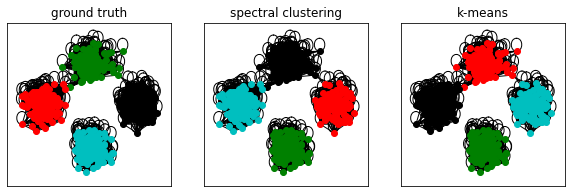

𝜎^2 = 0.3


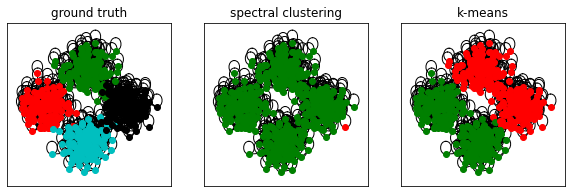

𝜎^2 = 0.5


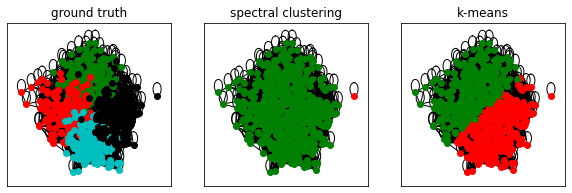

𝜎^2 = 1


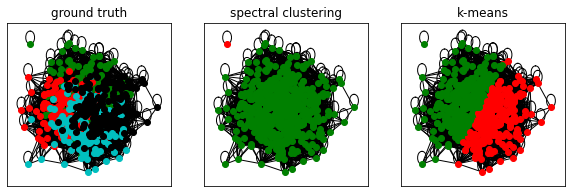

In [21]:
for var in [0.05, 0.15, 0.2, 0.3, 0.5, 1]:
    print(f"𝜎^2 = {var}")
    X, Y = blobs(num_samples=600, n_blobs=4, blob_var=var)
    plot_different_eigen(X,Y, eig = None, num_classes = None, graph= "disconnected", show=False)
    plt.show()

First when `chosen_eig_indices=None` was answered in question 2.1 - 2.2. However that was assuming that we knew how many clusters there are i.e. $n$. Suppose that we do not know the number of clusters i.e. in the algorithm `num_classes=None`.

Then to choose the number of classes we use an Eigen gap heuristic. In other words we are looking for the "first" $k$ eigenvalues such that they are close to zero and the $k+1$ eigenvalue is bigger. To do so we use the following heuristic function:

$$ k = \arg\max_{i} \frac{\lambda_{i+1}-\lambda_{i}}{i^2}$$

where $\lambda_i$ is the i-th eigenvalue. The numerator corresponds to trying to find the gap in the spectrum, while the denominator will favor "early" gaps more than "later" gaps. We chose to add the denominator because when plotting the two-moon spectrum we notice that it grows quadratically with no significant gaps. Hence this term was neccessary to give a good estimation. 

As seen above in the first Figure, this heuristic indeed gives very good results for different types of clean data e.g. blobs, 2 moons, 2 circles. We insist on the fact that the data has to be clean because the heuristic function is still very sensible to noise in the spectrum, which arises from noise in the graph. To demonstrate this (Figure 2) we observe that as the variance increases and the blobs merge, the estimation from the heuristic degenerates. Hence it considers the outliers as a separate cluster from the main blob of data. 


### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

When builidng the cluster assignment we used k-means. Thresholding could work, however it's use would be very limited as it would give good predictions only if the eigenvectors selected are indeed good indicator functions of the clusters, on the other hand, k-means is more versatile. Hence while thresholding might be a descent choice for the unnormalized and random walk laplacians (which theoretically yield indicator functions for the eigenvalues) it would not work for the symmetric laplacian (which eigenvalues are multiplied by $D^{1/2}$).

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

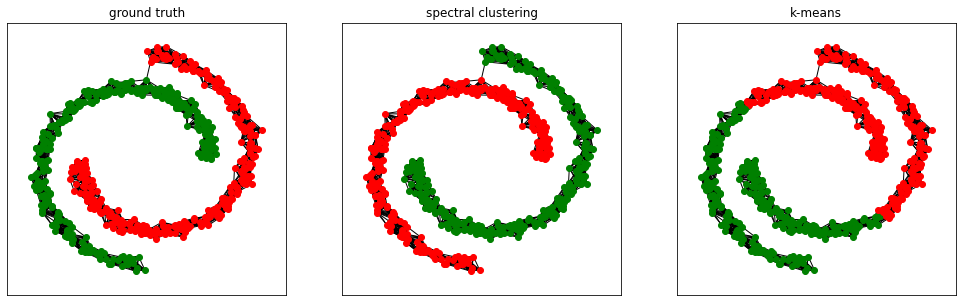

In [28]:
fig, ax = plt.subplots(1,3, figsize=(17,5))
X, Y = two_moons(num_samples=600)
W = build_similarity_graph(X, k=16)
L = build_laplacian(W)
Y_rec, _ = spectral_clustering(L, chosen_eig_indices=None, num_classes=None)
# Plot results, comparing to KMeans
plot_clustering_result(X, Y, W, Y_rec, KMeans(2).fit_predict(X), ax)

# Remark: sometimes the two-moons randomly raise a ValueError due to sklearn issues. 
# If that happens re-run the notebook.

We see that spectral clustering is able to understand the complex structure of each cluster and separates them perfectly. On the other hand, k-means can only predict clusters which are at a given euclidean distance from a centroid which in this case is impossible and hence gives terrible performance because it cannot capture the structure of the data.

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

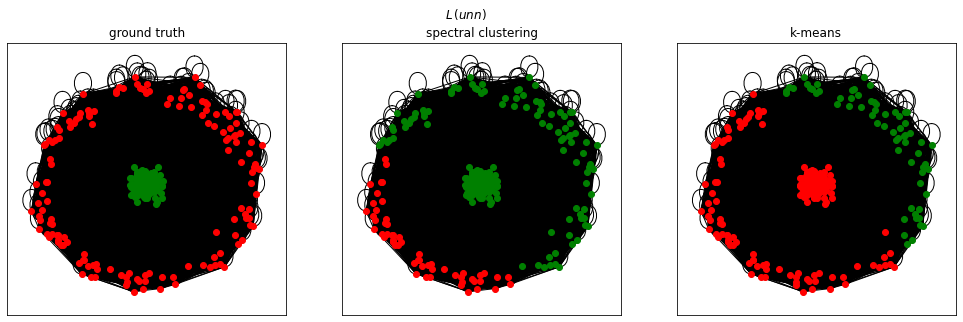

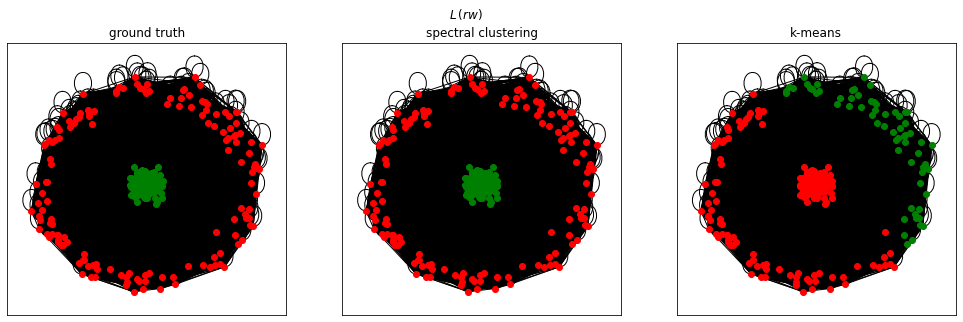

In [32]:
def compare_laplacian(X, Y, type_l='unn'):
    fig, ax = plt.subplots(1,3, figsize=(17,5))
    W = build_similarity_graph(X, eps=0,k=0, var=0.35)
    L = build_laplacian(W, type_l)
    Y_rec, _ = spectral_clustering(L, chosen_eig_indices=[1], num_classes=2)
    # Plot results, comparing to KMeans
    fig.suptitle(f"$L \, ({type_l})$")
    plot_clustering_result(X, Y, W, Y_rec, KMeans(2).fit_predict(X), ax)
    plt.show()
    
X, Y = point_and_circle(num_samples=300)
compare_laplacian(X,Y, 'unn')
compare_laplacian(X,Y, 'rw')

We see that the unnormalized laplacian does not manage to predict correctly the clustering for the two circles while the random walk laplacian is able to. As seen in the lecture the unnormalized laplacian solves a relaxation of the RatioCut problem while the random walk laplacian solves a relaxation of the NCut problem. The difference between the two comes from the fact that both RatioCut and NCut try to minimize the similarity between disctinct clusters, however on top of this NCut tries to maximize the similarity within a cluster. This pushes the algorithm to converge to solutions where clusters have similar densities and hence why it performs better on the two circle data.

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

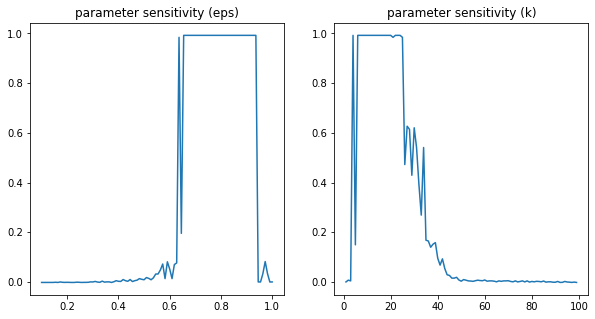

In [37]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
parameter_sensitivity(ax[0], 'eps', np.linspace(0.1, 1, 100))
parameter_sensitivity(ax[1], 'k', np.arange(1, 100))
plt.show()

We see that in both cases there is a specific range a values where the clustering plateau's at a perfect accuracy. However outside of this range it decays extremely quickly hence choosing a good $\epsilon$ and $k$ is essential if we want the spectral clustering to work. The ranges found experimentally are $]0.6, 0.9]$ for $\epsilon$ and $[10, 20]$ for $k$.

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

If we have no access to "true" labels then we cannot use any extrinsic evaluation method such as the Adjusted Rand index (as we are doing now), the Fowlkes-Mallows scores or V-measure for example. We have to use intrinsic measures such as Silhouette Coefficient, the Calinski-Harabasz Index or the Davies-Bouldin Index for example. The main idea being finding some heuristic way of characterizing the similarity of two points in the data, then compute the inter-cluster similarities and intra-cluster similarities which we use to build a score which is increasing with intra-cluster similarities and decreasing with inter-cluster similarities.

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

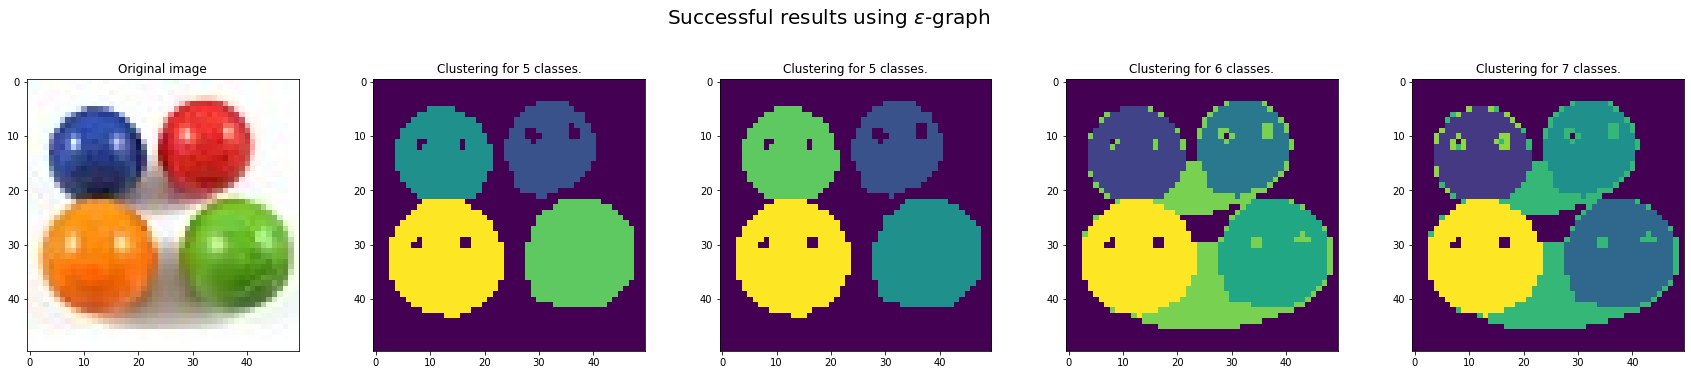

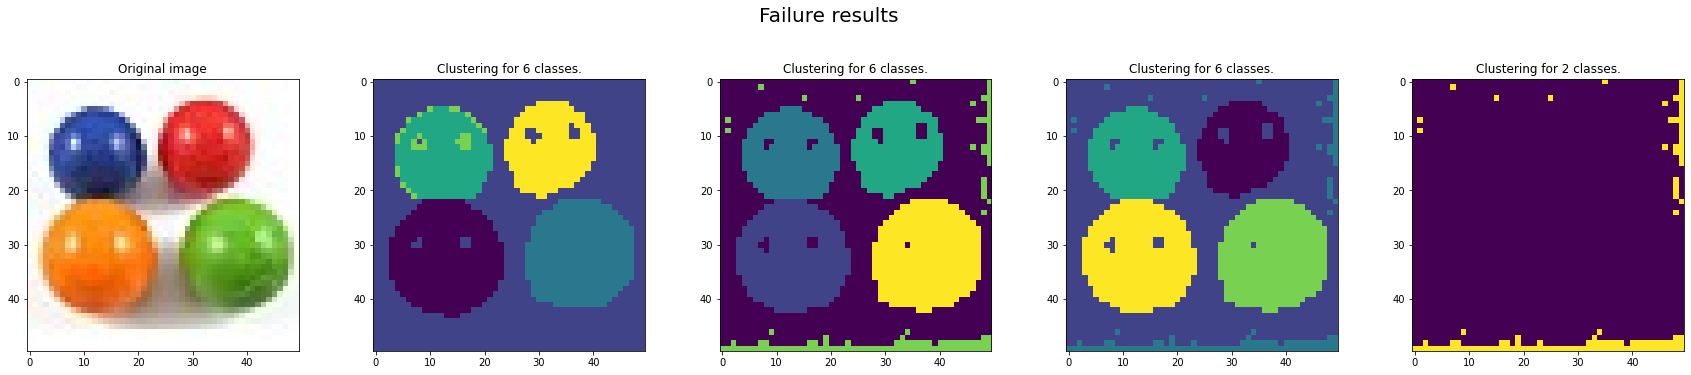

In [71]:
fig, ax = plt.subplots(1,5, figsize=(30,5))
fig.suptitle(f"Successful results using $\epsilon$-graph", size=20, y=1.08)
image_segmentation(ax[:2], input_img='four_elements.bmp', show_orig= True, num_classes = 5, laplacian_normalization='unn', eps=None)
image_segmentation(ax[2:], input_img='four_elements.bmp', show_orig= False, num_classes = 5, laplacian_normalization='rw', eps=None )
image_segmentation(ax[3:], input_img='four_elements.bmp', show_orig= False, num_classes = 6, laplacian_normalization='rw', eps=None )
image_segmentation(ax[4:], input_img='four_elements.bmp', show_orig= False, num_classes = None, laplacian_normalization='rw', eps=None )
plt.show()

fig, ax = plt.subplots(1,5, figsize=(30,5))
fig.suptitle(f"Failure results", size= 20, y=1.08)
image_segmentation(ax[:2], input_img='four_elements.bmp', show_orig= True, num_classes = 6, laplacian_normalization='unn', eps=None)
image_segmentation(ax[2:], input_img='four_elements.bmp', show_orig= False, num_classes = 6, laplacian_normalization='unn', k=16 )
image_segmentation(ax[3:], input_img='four_elements.bmp', show_orig= False, num_classes = 6, laplacian_normalization='rw', k=16 )
image_segmentation(ax[4:], input_img='four_elements.bmp', show_orig= False, num_classes = 6, laplacian_normalization='sym', k=16)
image_segmentation(ax[4:], input_img='four_elements.bmp', show_orig= False, num_classes = None, laplacian_normalization='rw', k=16)
plt.show()

Above we have displayed some of the successful results and failure cases of the spectral clustering algorithm for clustering the four balloons. 
- We start by comparing which graph ($\epsilon$ or kNN) has a better performance. As we can see in general the $\epsilon$ is able to give well defined clusters corresponding to the 4 balloons, shadows and background. However the kNN has more noise present and clusters certain background pixels as the balloons. This is to be expected since the image is relatively clean (i.e. no significant outliers are present) and hence by using the `how_to_choose_epsilon` function we obtain an optimal value of $\epsilon$.
- Second we compare different laplacian normalization for different number of classes. The unnormalized laplacian has an acceptable performance for 5 clusters (4 balloons, background), however when we ask to cluster 6 elements it fails. On the other hand the random-walk normalization is much more versatile. This is to be expected as in this image all clusters are of similar volume as seen in Question 2.6. The symmetric normalization did not perform well as this is probably due to the fact that eigenvectors of the symmetric laplacian are not indicator functions as discussed in Question 2.4
- Lastly we would like to test if the spectral clustering algorithm is able to cluster when no classes are given i.e `num_classes=None`. Indeed the algorithm performs very well with a random-walk laplacian and $\epsilon$-graph for the reasons detailed above. Furthermore we notice that the algorithm chooses to classify into 7 classes instead of 6. The 7th class is the contour of the blue balloon and reflection on the blue balloon. To the naked eye we do not notice such clustering in the original image, however the predicted clusters are still very good. 


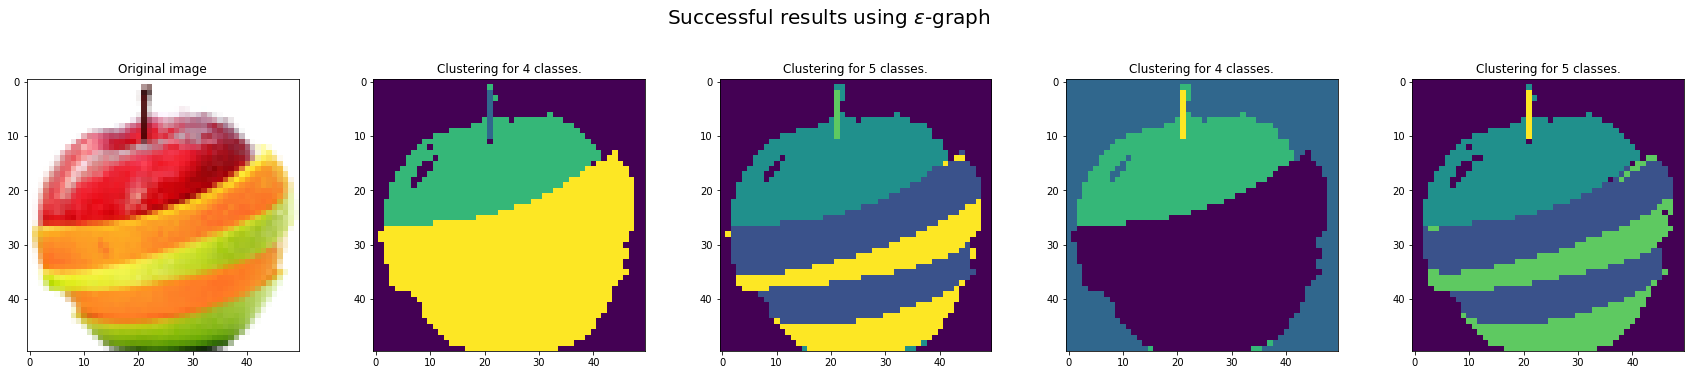

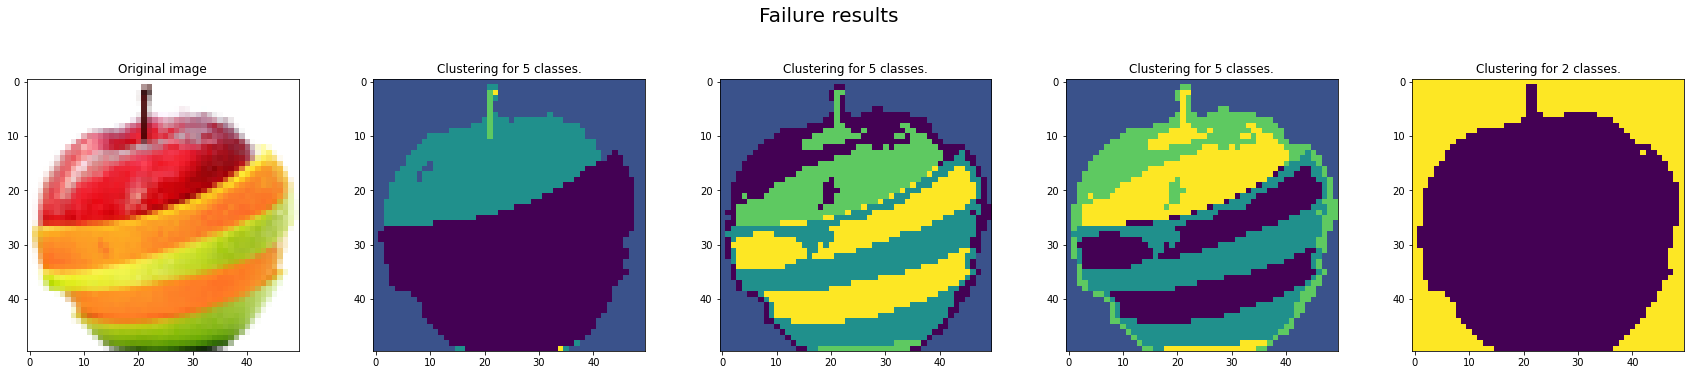

In [75]:
fig, ax = plt.subplots(1,5, figsize=(30,5))
fig.suptitle(f"Successful results using $\epsilon$-graph", size=20, y=1.08)
image_segmentation(ax[:2], input_img='fruit_salad.bmp', show_orig= True, num_classes = None, laplacian_normalization='sym', eps=None)
image_segmentation(ax[2:], input_img='fruit_salad.bmp', show_orig= False, num_classes = 5, laplacian_normalization='rw', eps=None )
image_segmentation(ax[3:], input_img='fruit_salad.bmp', show_orig= False, num_classes = None, laplacian_normalization='rw', eps=None )
image_segmentation(ax[4:], input_img='fruit_salad.bmp', show_orig= False, num_classes = 5, laplacian_normalization='sym', eps=None )
plt.show()

fig, ax = plt.subplots(1,5, figsize=(30,5))
fig.suptitle(f"Failure results", size= 20, y=1.08)
image_segmentation(ax[:2], input_img='fruit_salad.bmp', show_orig= True, num_classes = 5, laplacian_normalization='unn', eps=None)
image_segmentation(ax[2:], input_img='fruit_salad.bmp', show_orig= False, num_classes = 5, laplacian_normalization='unn', k=16 )
image_segmentation(ax[3:], input_img='fruit_salad.bmp', show_orig= False, num_classes = 5, laplacian_normalization='rw', k=16 )
image_segmentation(ax[4:], input_img='fruit_salad.bmp', show_orig= False, num_classes = None, laplacian_normalization='rw', k=16)
plt.show()

As before we perform the same steps and notice that in general the above conclusions hold for this picture as well, with the following expections/remarks:
- The symmetric laplacian performs almost identically to the random-walk laplacian. 
- When number of classes is not specified the spectral clustering chooses 4 clusters (background, apple, stem and other), which is a slight underestimation since all the stripes are grouped together. However for a heuristic estimation it is still a pretty good result. On the other hand when using a kNN graph instead of an $\epsilon$-graph the heuristic spectral clustering algorithm detects only 2 clusters. This goes to show that kNN performs worse in these clean images. 

Remark: The first image of the failure cases might seem good but it was supposed to find 5 clusters and instead grouped the stripes and selected a random outlier as a cluster. 



### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

The easiest way to perform spectral clustering on large images is simply to downscale the image, perform the clustering on the downscaled image and then upscale the image. Of course this will yield a much worse solution than if we were able to directly cluster the large image, however it will still be a decent clustering and it has the merit of being easily adaptable so if we have more (resp. less) computing power we can downsample less (resp. more).
Another option would be to work around the computationally expensive step i.e. the eigenvalue problem. Since we are only interested in the first $k$ eigenvectors we could use Lanczos algorithm to approximate these eigenvectors instead of computing them exactly. This would reduce the computational cost drastically. However the full graph would still be extremely costly, hence we could also store a 'patch-based' approximation of the actual full-graph.

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

In [87]:
import urllib.request
from PIL import Image
  
urllib.request.urlretrieve(
  'https://github.com/MegiDervishi/mva/blob/main/graphs_ml/larger.jpg?raw=true',
   "large.png")
  
img = Image.open("large.png")
img.save("./data/large.png")

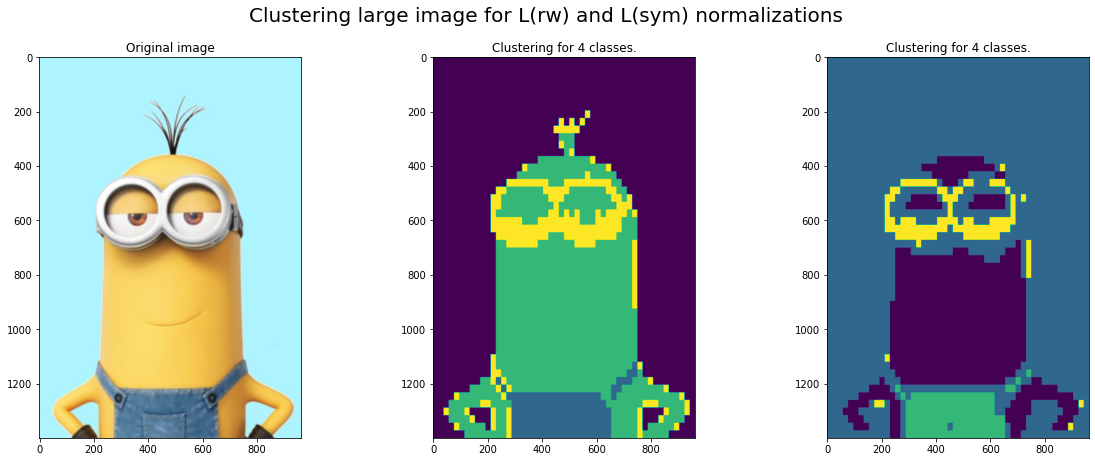

In [102]:
fig, ax = plt.subplots(1,3, figsize=(20,7))
fig.suptitle("Clustering large image for L(rw) and L(sym) normalizations", size=20)
image_segmentation(ax[:2], input_img='large.png', show_orig=True, large = True, eps=None, num_classes = None, laplacian_normalization = 'rw')
image_segmentation(ax[2:], input_img='large.png', show_orig=False, large = True, eps=None, num_classes = None, laplacian_normalization = 'sym')
plt.show()


To perform spectral clustering on the above large image we have implemented the downsample-upsample technique described in Question 3.2. Indeed the performance of this algorithm is very good. The first clustering is done with a random-walk laplacian and the second one with a symmetric one. Both have resulted in 4 clusters. However the $L_{sym}$ considers the "hair" as part of the background whereas the random walk as part of the minion. 

## References

1. http://www.tml.cs.uni-tuebingen.de/team/luxburg/publications/Luxburg07_tutorial.pdf
2. https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-download-auto-examples-cluster-plot-cluster-comparison-py
3. http://vargas-solar.com/data-centric-smart-everything/hands-on/unsupervised-learning-comparing-clustering-methods/